             seq_name     start       end                         region_id  \
0  haplotype1-0000001         6   3687872  1cd8d5bfea00e572870d4e077f86580f   
1  haplotype1-0000001   4196746  56421431  1601ad22f6eb1473615f0f450d68bdd3   
2  haplotype1-0000001  11664139  11675172  3fa62c746e9181463a7f7de4ad7b4b4f   
3  haplotype1-0000001  56421598  67030088  47e768f833a46a086d5600fc62ec3cc8   
4  haplotype1-0000001  67035349  75775493  ecc173154af629d2b1fd05be8981802d   

   exact_qv   sample   direction  struct_qv  
0        29  HG00096  hsm-to-vrk         29  
1        44  HG00096  hsm-to-vrk         45  
2        15  HG00096  hsm-to-vrk         99  
3        44  HG00096  hsm-to-vrk         45  
4        51  HG00096  hsm-to-vrk         99  
(62762, 8)


Text(0, 0.5, 'QV estimate (error mode: struct)')

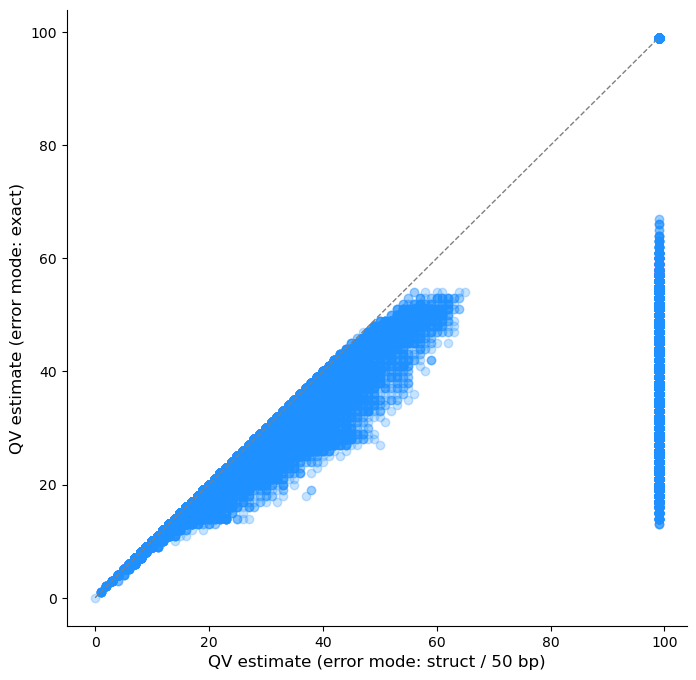

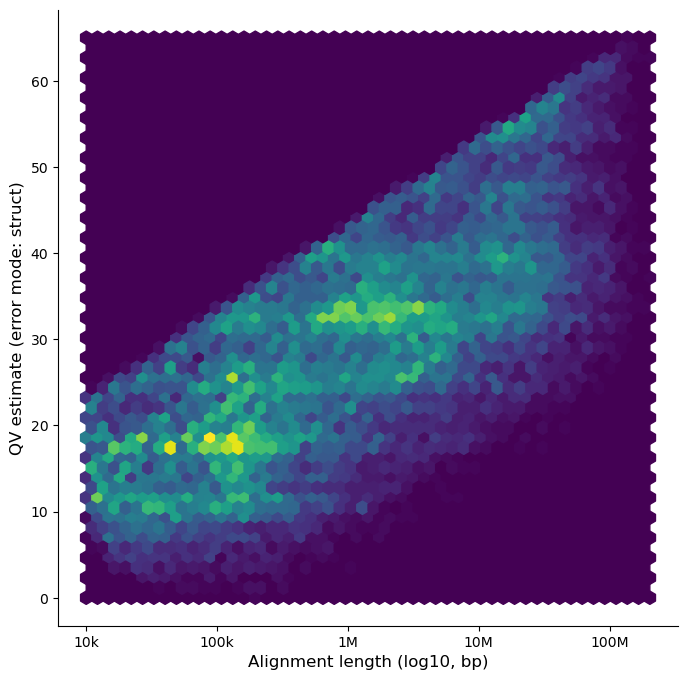

In [39]:
import pandas as pd
import pathlib as pl
import re
import functools as fnt
import math
import numpy as np
import numpy.ma as msk
import collections as col
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial as poly

folders = [
    pl.Path("/home/ebertp/work/projects/hgsvc/2024_asm_compare/regions/hsm-to-vrk"),
    pl.Path("/home/ebertp/work/projects/hgsvc/2024_asm_compare/regions/vrk-to-hsm")
]

pattern = "mapq-1.seq-100k.aln-10k"

for folder in folders:
    if not folder.is_dir():
        continue
    direction = folder.name

    merged = []
    stats_files = folder.glob(f"*{pattern}*.tsv.gz")
    sample_stats = None
    for stats_file in sorted(stats_files):
        df = pd.read_csv(stats_file, sep="\t", header=0)
        if "exact" in stats_file.name:
            #df["is_exact"] = 1
            df.rename({"qv": "exact_qv"}, axis=1, inplace=True)
        else:
            #df["is_exact"] = 0
            df.rename({"qv": "struct_qv"}, axis=1, inplace=True)
        sample = stats_file.name.split(".")[0]
        df["sample"] = sample
        df["direction"] = direction
        if sample_stats is None:
            sample_stats = df.copy()
            continue
        else:
            assert sample_stats["sample"].nunique() == 1
            sample_stats = pd.merge(
                sample_stats, df,
                on=["seq_name", "start", "end", "region_id", "sample", "direction"],
                how="outer"
            )
            if "struct_qv_x" in sample_stats:
                sample_stats = None
                continue
            merged.append(sample_stats)
            sample_stats = None

    merged = pd.concat(merged, axis=0, ignore_index=False)
print(merged.head())
print(merged.shape)

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(
    merged["struct_qv"],
    merged["exact_qv"],
    alpha=0.25,
    color="dodgerblue"
)

ax.plot(
    np.arange(0,100),
    np.arange(0,100),
    color="grey",
    zorder=1,
    ls="--",
    lw=1
)

ax.set_xlabel("QV estimate (error mode: struct / 50 bp)", fontsize=12)
ax.set_ylabel("QV estimate (error mode: exact)", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


fig, ax = plt.subplots(figsize=(8,8))

plot_mode = "struct"

if plot_mode == "struct":

    sub = merged.loc[merged["struct_qv"] < 99, :].copy()
    aln_lens = np.log10(sub["end"] - sub["start"])
    qv_vals = sub["struct_qv"]

if plot_mode == "exact":
    aln_lens = np.log10(merged["end"] - merged["start"])
    qv_vals = merged["exact_qv"]

ax.hexbin(
    aln_lens,
    qv_vals,
    gridsize=50
)

# ax.scatter(
#     aln_lens,
#     merged["struct_qv"],
#     alpha=0.25,
#     color="blue"
# )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.set_xticks([4,5,6,7,8])
ax.set_xticklabels(["10k", "100k", "1M", "10M", "100M"], fontsize=10)
ax.set_xlabel("Alignment length (log10, bp)", fontsize=12)
ax.set_ylabel(f"QV estimate (error mode: {plot_mode})", fontsize=12)


# trendline = poly.fit(fit_x, fit_y, 1)

# fig, ax = plt.subplots(figsize=(8,8))

# ax.scatter(
#     xvals,
#     yvals,
#     s=20,
#     color=colors,
#     alpha=0.7
# )

# polyfit_x, polyfit_y = trendline.linspace()
# ax.plot(
#     polyfit_x,
#     polyfit_y,
#     ls="solid",
#     lw=1,
#     color="red"
# )
